# Solar Panel Power Prediction & Dust Detection Pipeline

## Project Overview
This notebook demonstrates the complete Machine Learning Pipeline for determining solar panel performance. The goal is to predict the **expected (ideal) power output** based on weather conditions. By comparing this prediction with the actual output, we can identify performance degradation caused by dust accumulation.

### Pipeline Steps:
1.  **Data Loading**: Reading Generation and Weather datasets.
2.  **Data Preprocessing**: Merging, cleaning, and handling timestamps.
3.  **Feature Engineering**: Creating useful features like `HOUR` and `MONTH`.
4.  **Model Selection**: Training and comparing **Linear Regression**, **Random Forest**, and **XGBoost**.
5.  **Evaluation**: Selecting the best model based on R2 Score and RMSE.
6.  **Saving**: Exporting the model for the Web Application.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
# Settings
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

## 1. Data Loading
We use the **Plant 1** datasets: Generation Data (Inverter level) and Weather Data (Plant level).

In [2]:
# Load Datasets
gen_df = pd.read_csv('datasets/Plant_1_Generation_Data.csv')
weather_df = pd.read_csv('datasets/Plant_1_Weather_Sensor_Data.csv')

print("Generation Data Shape:", gen_df.shape)
print("Weather Data Shape:", weather_df.shape)

Generation Data Shape: (68778, 7)
Weather Data Shape: (3182, 6)


## 2.1 Data Quality Assessment
Understanding the data before cleaning - checking for missing values, duplicates, and basic statistics.

In [3]:
# Data Quality Assessment
print("="*60)
print("GENERATION DATA QUALITY ASSESSMENT")
print("="*60)
print(f"\nShape: {gen_df.shape}")
print(f"\nData Types:\n{gen_df.dtypes}")
print(f"\nMissing Values:\n{gen_df.isnull().sum()}")
print(f"\nDuplicate Rows: {gen_df.duplicated().sum()}")
print(f"\nBasic Statistics:\n{gen_df.describe()}")

print("\n" + "="*60)
print("WEATHER DATA QUALITY ASSESSMENT")
print("="*60)
print(f"\nShape: {weather_df.shape}")
print(f"\nData Types:\n{weather_df.dtypes}")
print(f"\nMissing Values:\n{weather_df.isnull().sum()}")
print(f"\nDuplicate Rows: {weather_df.duplicated().sum()}")
print(f"\nBasic Statistics:\n{weather_df.describe()}")

# Check for zero values (these are VALID!)
print(f"\n Zero values in generation data (valid night readings):")
print(f"   DC_POWER = 0: {(gen_df['DC_POWER'] == 0).sum():,} records")
print(f"   AC_POWER = 0: {(gen_df['AC_POWER'] == 0).sum():,} records")

print(f"\n Zero values in weather data (valid night readings):")
print(f"   IRRADIATION = 0: {(weather_df['IRRADIATION'] == 0).sum():,} records")

GENERATION DATA QUALITY ASSESSMENT

Shape: (68778, 7)

Data Types:
DATE_TIME       object
PLANT_ID         int64
SOURCE_KEY      object
DC_POWER       float64
AC_POWER       float64
DAILY_YIELD    float64
TOTAL_YIELD    float64
dtype: object

Missing Values:
DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64

Duplicate Rows: 0

Basic Statistics:
        PLANT_ID      DC_POWER      AC_POWER   DAILY_YIELD   TOTAL_YIELD
count    68778.0  68778.000000  68778.000000  68778.000000  6.877800e+04
mean   4135001.0   3147.426211    307.802752   3295.968737  6.978712e+06
std          0.0   4036.457169    394.396439   3145.178309  4.162720e+05
min    4135001.0      0.000000      0.000000      0.000000  6.183645e+06
25%    4135001.0      0.000000      0.000000      0.000000  6.512003e+06
50%    4135001.0    429.000000     41.493750   2658.714286  7.146685e+06
75%    4135001.0   6366.964286    623.618750   6274.000000  

## 2.2 Data Cleaning
Removing duplicates, negative values, and outliers while **preserving valid zero values** (night-time data).

In [5]:
# Data Cleaning
print("Starting data cleaning...")
print(f"Initial shapes - Gen: {gen_df.shape}, Weather: {weather_df.shape}")

# 1. Remove duplicates
gen_df_before = len(gen_df)
gen_df = gen_df.drop_duplicates()
print(f"\nDuplicates removed from generation data: {gen_df_before - len(gen_df)}")

weather_df_before = len(weather_df)
weather_df = weather_df.drop_duplicates()
print(f"Duplicates removed from weather data: {weather_df_before - len(weather_df)}")

# 2. Remove ONLY negative values (NOT zeros!)
#  IMPORTANT: Zero values are VALID (e.g., night time, no solar production)
# We only remove negative values which are physically impossible

print(f"\n Note: Zero values in power/irradiation are KEPT (valid night readings)")

negative_power = (gen_df['DC_POWER'] < 0).sum()
gen_df = gen_df[gen_df['DC_POWER'] >= 0]  # Keep zeros 
gen_df = gen_df[gen_df['AC_POWER'] >= 0]   # Keep zeros 
gen_df = gen_df[gen_df['DAILY_YIELD'] >= 0]  # Keep zeros 
print(f"Negative power values removed: {negative_power}")

# Check how many zero values we're keeping (these are valid!)
zero_power_count = (gen_df['DC_POWER'] == 0).sum()
print(f"Zero power values KEPT (night time): {zero_power_count:,}")

# 3. Remove outliers using IQR method ONLY for non-zero values
# This prevents removing valid night-time data
def remove_outliers_smart(df, column):
    """Remove outliers only from non-zero values"""
    # Separate zero and non-zero
    zeros = df[df[column] == 0]
    non_zeros = df[df[column] > 0]
    
    if len(non_zeros) == 0:
        return df
    
    # Apply IQR only to non-zero values
    Q1 = non_zeros[column].quantile(0.25)
    Q3 = non_zeros[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter non-zeros
    non_zeros_clean = non_zeros[(non_zeros[column] >= lower_bound) & 
                                 (non_zeros[column] <= upper_bound)]
    
    # Combine back with zeros
    return pd.concat([zeros, non_zeros_clean], ignore_index=True)

gen_df_before = len(gen_df)
gen_df = remove_outliers_smart(gen_df, 'DC_POWER')
gen_df = remove_outliers_smart(gen_df, 'AC_POWER')
print(f"Outliers removed (zeros preserved): {gen_df_before - len(gen_df)}")

# 4. Clean weather data - remove impossible values
# Note: IRRADIATION = 0 is valid (night time) 
weather_df_before = len(weather_df)

weather_df = weather_df[weather_df['AMBIENT_TEMPERATURE'] >= -10]  # Realistic minimum
weather_df = weather_df[weather_df['AMBIENT_TEMPERATURE'] <= 60]   # Realistic maximum
weather_df = weather_df[weather_df['MODULE_TEMPERATURE'] >= -10]   
weather_df = weather_df[weather_df['MODULE_TEMPERATURE'] <= 80]    
weather_df = weather_df[weather_df['IRRADIATION'] >= 0]  # Keep zeros (night) 
weather_df = weather_df[weather_df['IRRADIATION'] <= 1.5]  # Max realistic value

print(f"Weather outliers removed: {weather_df_before - len(weather_df)}")

# 5. Verify zero values are still present
print(f"\n Verification - Valid zero values preserved:")
print(f"   DC_POWER = 0: {(gen_df['DC_POWER'] == 0).sum():,} records")
print(f"   IRRADIATION = 0: {(weather_df['IRRADIATION'] == 0).sum():,} records")

print(f"\n After cleaning:")
print(f"   Generation data: {gen_df.shape}")
print(f"   Weather data: {weather_df.shape}")

Starting data cleaning...
Initial shapes - Gen: (68778, 7), Weather: (3182, 6)

Duplicates removed from generation data: 0
Duplicates removed from weather data: 0

 Note: Zero values in power/irradiation are KEPT (valid night readings)
Negative power values removed: 0
Zero power values KEPT (night time): 31,951
Outliers removed (zeros preserved): 0
Weather outliers removed: 0

 Verification - Valid zero values preserved:
   DC_POWER = 0: 31,951 records
   IRRADIATION = 0: 1,425 records

 After cleaning:
   Generation data: (68778, 7)
   Weather data: (3182, 6)


## 2. Data Preprocessing
- **Standardize Time**: Convert `DATE_TIME` to datetime objects.
- **Merge**: Join datasets on `DATE_TIME` to associate weather with power generation.

In [6]:
# Convert to datetime
gen_df['DATE_TIME'] = pd.to_datetime(gen_df['DATE_TIME'], format='mixed', dayfirst=True)
weather_df['DATE_TIME'] = pd.to_datetime(weather_df['DATE_TIME'], format='mixed', dayfirst=True)

# Merge Data (Left join to keep all generation records)
merged_df = pd.merge(gen_df, weather_df, on=["DATE_TIME", "PLANT_ID"], how="left")

# Drop rows with missing weather data (if any)
merged_df = merged_df.dropna(subset=['IRRADIATION', 'MODULE_TEMPERATURE'])

print("Merged Data Shape:", merged_df.shape)
merged_df.head()

Merged Data Shape: (68774, 11)


,DATE_TIME,PLANT_ID,SOURCE_KEY_x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,SOURCE_KEY_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
2,2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
3,2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
4,2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0


## 2.3 Post-Merge Data Validation
Validating the quality of merged data and checking correlations.

In [7]:
# Post-Merge Data Validation
print("="*60)
print("MERGED DATA VALIDATION")
print("="*60)

# Check for remaining issues
print(f"\n1. Total records: {len(merged_df):,}")
print(f"\n2. Date range: {merged_df['DATE_TIME'].min()} to {merged_df['DATE_TIME'].max()}")
print(f"\n3. Missing values:\n{merged_df.isnull().sum()}")
print(f"\n4. Negative values check:")
print(f"   - DC_POWER negatives: {(merged_df['DC_POWER'] < 0).sum()}")
print(f"   - AC_POWER negatives: {(merged_df['AC_POWER'] < 0).sum()}")

# Verify zero values are preserved
print(f"\n5. Zero values preserved (VALID night data):")
print(f"   - DC_POWER = 0: {(merged_df['DC_POWER'] == 0).sum():,} records")
print(f"   - IRRADIATION = 0: {(merged_df['IRRADIATION'] == 0).sum():,} records")

print(f"\n6. Data completeness:")
for col in merged_df.columns:
    completeness = (1 - merged_df[col].isnull().sum() / len(merged_df)) * 100
    print(f"   - {col}: {completeness:.2f}%")

# Correlation matrix for key variables
print(f"\n7. Correlation with DC_POWER:")
correlations = merged_df[['DC_POWER', 'IRRADIATION', 'MODULE_TEMPERATURE', 
                           'AMBIENT_TEMPERATURE']].corr()['DC_POWER'].sort_values(ascending=False)
print(correlations)

MERGED DATA VALIDATION

1. Total records: 68,774

2. Date range: 2020-05-15 00:00:00 to 2020-06-17 23:45:00

3. Missing values:
DATE_TIME              0
PLANT_ID               0
SOURCE_KEY_x           0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
SOURCE_KEY_y           0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64

4. Negative values check:
   - DC_POWER negatives: 0
   - AC_POWER negatives: 0

5. Zero values preserved (VALID night data):
   - DC_POWER = 0: 31,951 records
   - IRRADIATION = 0: 30,398 records

6. Data completeness:
   - DATE_TIME: 100.00%
   - PLANT_ID: 100.00%
   - SOURCE_KEY_x: 100.00%
   - DC_POWER: 100.00%
   - AC_POWER: 100.00%
   - DAILY_YIELD: 100.00%
   - TOTAL_YIELD: 100.00%
   - SOURCE_KEY_y: 100.00%
   - AMBIENT_TEMPERATURE: 100.00%
   - MODULE_TEMPERATURE: 100.00%
   - IRRADIATION: 100.00%

7. Correlation with DC_POWER:
DC_POWER               1.000000
IRRADIAT

## 2.4 Data Quality Visualization
Visual inspection of cleaned data distributions and relationships.

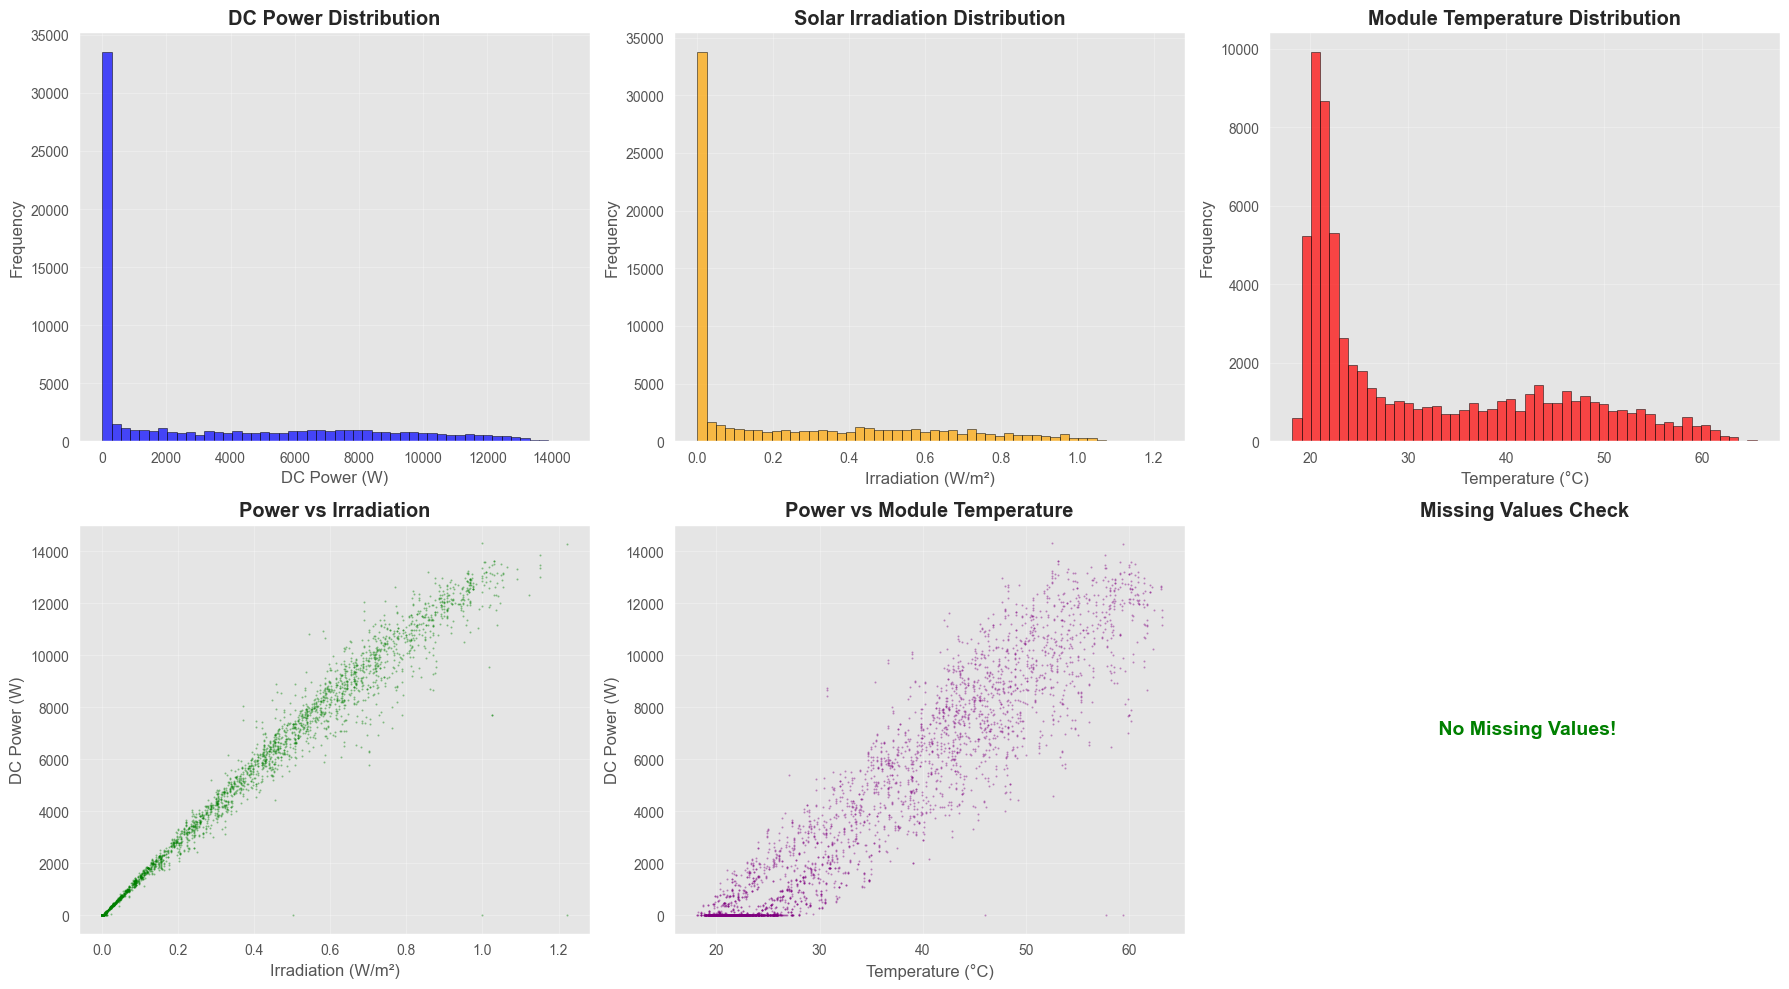


 Data quality visualization complete!
 Final cleaned dataset: (68774, 11)


In [9]:
# Data Quality Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. DC_POWER distribution
axes[0, 0].hist(merged_df['DC_POWER'], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].set_title('DC Power Distribution', fontweight='bold')
axes[0, 0].set_xlabel('DC Power (W)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(alpha=0.3)

# 2. IRRADIATION distribution
axes[0, 1].hist(merged_df['IRRADIATION'], bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[0, 1].set_title('Solar Irradiation Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Irradiation (W/m²)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(alpha=0.3)

# 3. Temperature distribution
axes[0, 2].hist(merged_df['MODULE_TEMPERATURE'], bins=50, alpha=0.7, color='red', edgecolor='black')
axes[0, 2].set_title('Module Temperature Distribution', fontweight='bold')
axes[0, 2].set_xlabel('Temperature (°C)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].grid(alpha=0.3)

# 4. Power vs Irradiation scatter
sample = merged_df.sample(min(5000, len(merged_df)))
axes[1, 0].scatter(sample['IRRADIATION'], sample['DC_POWER'], alpha=0.3, s=1, color='green')
axes[1, 0].set_title('Power vs Irradiation', fontweight='bold')
axes[1, 0].set_xlabel('Irradiation (W/m²)')
axes[1, 0].set_ylabel('DC Power (W)')
axes[1, 0].grid(alpha=0.3)

# 5. Power vs Temperature scatter
axes[1, 1].scatter(sample['MODULE_TEMPERATURE'], sample['DC_POWER'], alpha=0.3, s=1, color='purple')
axes[1, 1].set_title('Power vs Module Temperature', fontweight='bold')
axes[1, 1].set_xlabel('Temperature (°C)')
axes[1, 1].set_ylabel('DC Power (W)')
axes[1, 1].grid(alpha=0.3)

# 6. Missing values bar chart
missing_data = merged_df.isnull().sum()
if missing_data.sum() > 0:
    axes[1, 2].barh(missing_data.index, missing_data.values, color='coral', edgecolor='black')
    axes[1, 2].set_title('Missing Values per Column', fontweight='bold')
    axes[1, 2].set_xlabel('Count')
    axes[1, 2].tick_params(axis='y', labelsize=8)
else:
    axes[1, 2].text(0.5, 0.5, ' No Missing Values!', 
                    ha='center', va='center', fontsize=14, fontweight='bold', color='green')
    axes[1, 2].set_title('Missing Values Check', fontweight='bold')
    axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("\n Data quality visualization complete!")
print(f" Final cleaned dataset: {merged_df.shape}")

## 3. Feature Engineering
Solar power is highly dependent on the time of day and season. We extract:
- `HOUR`: For daily cycles.
- `MONTH`: For seasonal cycles.

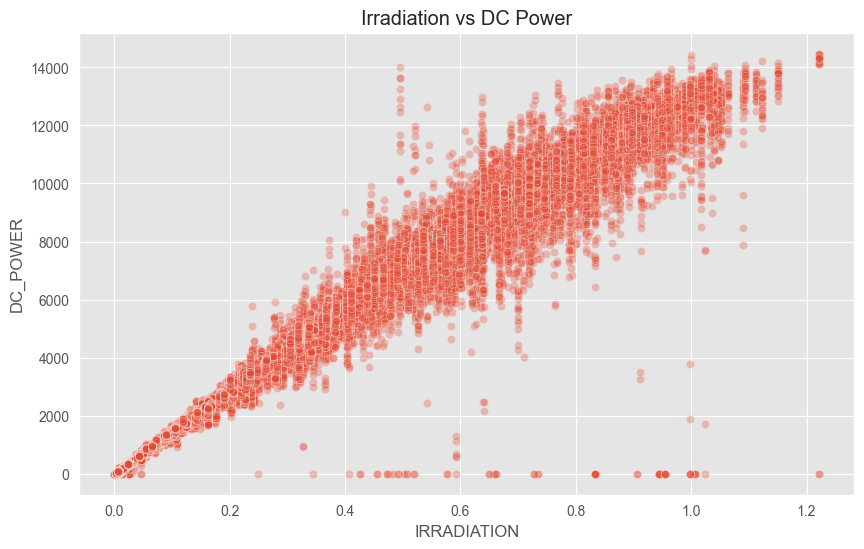

In [10]:
merged_df['HOUR'] = merged_df['DATE_TIME'].dt.hour
merged_df['MONTH'] = merged_df['DATE_TIME'].dt.month

# Visualize relationship between Irradiation and Power
plt.figure(figsize=(10, 6))
sns.scatterplot(x='IRRADIATION', y='DC_POWER', data=merged_df, alpha=0.3)
plt.title('Irradiation vs DC Power')
plt.show()

## 4. Model Selection & Training
We compare three regression models:
1.  **Linear Regression**: Simple baseline.
2.  **Random Forest**: Ensemble method, good for non-linearities.
3.  **XGBoost**: Gradient boosting, excellent for tabular data.

In [11]:
# Features and Target
features = ['IRRADIATION', 'MODULE_TEMPERATURE', 'HOUR', 'MONTH']
target = 'DC_POWER'

X = merged_df[features]
y = merged_df[target]

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
}

results = {}

# Train and Evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"RMSE": rmse, "R2": r2, "Model": model}
    print(f"{name} -> RMSE: {rmse:.2f}, R2: {r2:.4f}")

Linear Regression -> RMSE: 611.13, R2: 0.9771
Random Forest -> RMSE: 509.45, R2: 0.9841
XGBoost -> RMSE: 510.34, R2: 0.9840


## 5. Evaluation & Conclusion
We select the model with the highest R2 Score and lowest RMSE.

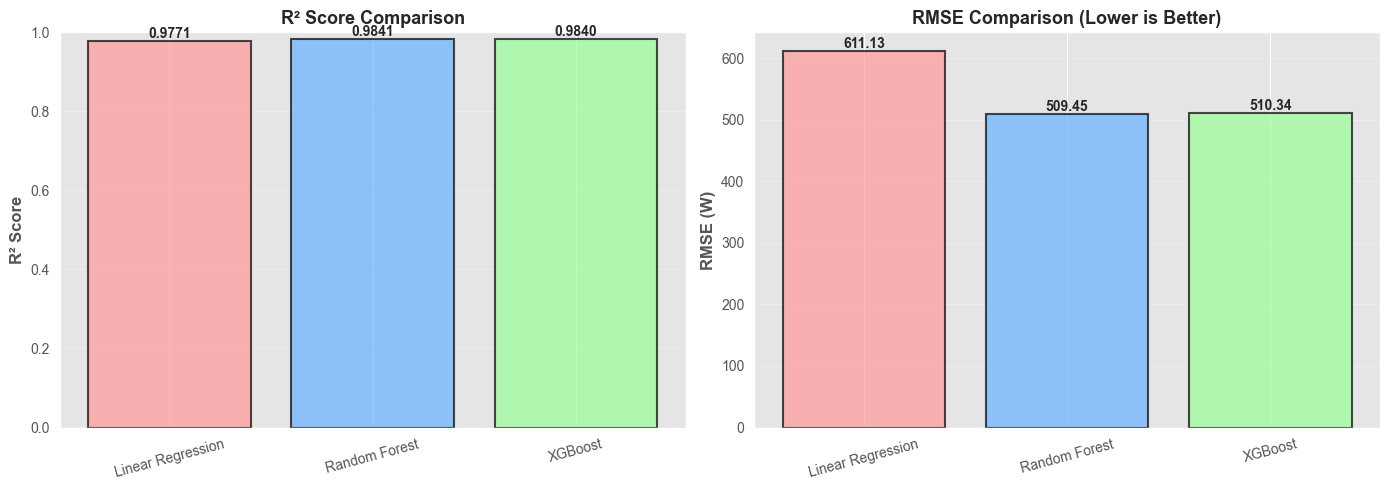

In [13]:
# Visualize Model Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Extract results for plotting
model_names = list(results.keys())
r2_scores = [results[model]['R2'] for model in model_names]
rmse_scores = [results[model]['RMSE'] for model in model_names]

colors = ['#ff9999', '#66b3ff', '#99ff99']

# R² Score Comparison
bars1 = axes[0].bar(model_names, r2_scores, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[0].set_title('R² Score Comparison', fontsize=13, fontweight='bold')
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=15)

# Add values on bars
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# RMSE Comparison
bars2 = axes[1].bar(model_names, rmse_scores, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('RMSE (W)', fontsize=12, fontweight='bold')
axes[1].set_title('RMSE Comparison (Lower is Better)', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=15)

# Add values on bars
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

In [14]:
# Find best model
best_model_name = max(results, key=lambda k: results[k]['R2'])
best_model = results[best_model_name]['Model']
best_r2 = results[best_model_name]['R2']

print(f"\n🏆 Best Model: {best_model_name} with R2 Score: {best_r2:.4f}")

# Save the best model
joblib.dump(best_model, 'solar_model.pkl')
print(f"Model saved to 'solar_model.pkl'")


🏆 Best Model: Random Forest with R2 Score: 0.9841
Model saved to 'solar_model.pkl'
